### Load Modules

In [1]:
from datetime import datetime
print(datetime.now())

2024-02-02 01:12:03.136061


In [2]:
# Restart the kernel
import os
import dill as pickle
current_dir ='../../'
os.chdir(current_dir)

from src.codes.basic import *
from src.codes.utils.plot_files.plot_utils import TwoDPlot as plot
from src.codes.utils.rom_utils import *
import time as time

import src.codes.prob_classes.base_class_heat_conduction_AM_ms as bc
# from src.codes.prob_classes.base_class_heat_conduction_AM import ROM_simulation 
# import src.codes.reductor.rom_class_AM as rom_class
from src.codes.algorithms.ecsw_t_AM_ms import ecsw_red_AM_ms

from importlib import reload

In [3]:
reload(bc)
# reload(rom_class)

<module 'src.codes.prob_classes.base_class_heat_conduction_AM_ms' from 'c:\\Users\\suparnob\\OneDrive - Texas A&M University\\Academic\\TAMU_MATERIALS\\POSTDOC\\HYPERREDUCTION\\SUPARNO\\HYPERREDUCTION__TAMIDS\\pyHyperRom\\src\\codes\\prob_classes\\base_class_heat_conduction_AM_ms.py'>

### Load data

In [4]:
filename_dataC = 'examples/Additive_Manufacturing/data/DataClass_AM_M.dill'
with open(filename_dataC, 'rb') as f:
    Data_cls = pickle.load(f)

In [5]:
# load required variables from data
FOS = Data_cls.FOS
d = FOS.data
mask = d.mask
param_list = np.asarray(Data_cls.param_list)
NLS = np.asarray(Data_cls.NL_solutions)
K_mus = Data_cls.K_mus
t = Data_cls.t
q_mus = Data_cls.q_mus

# train_mask, test_mask = Data_cls.train_mask, Data_cls.test_mask 

_,N_snap = np.shape(NLS[0])
print(N_snap)

10001


## ECSW Hyper-reduction

### Data-processing

Number of modes selected: 259


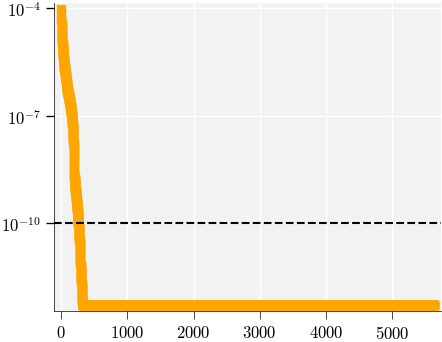

In [6]:
NLS_mask = NLS[0][mask]
plt.rcParams['figure.dpi'] = 100
n_sel, U = svd_mode_selector(NLS_mask.T, tolerance=1e-10,modes=True)

In [7]:
n_sel += 10
V_sel = U[:, :n_sel]

### Train-Test split

In [8]:
Snap_sel=200
train_mask, _ = train_test_split_sobol(N_snap, N_sel=Snap_sel)
NLS_train = NLS_mask[:,train_mask]

### Mean subtraction

In [9]:
NLS_train_mean = NLS_mask[:,0] #np.mean(NLS_mask,axis=1)
NLS_train_mean = NLS_train_mean.reshape(-1,1)
NLS_train_ms = NLS_train - NLS_train_mean

### Plot snapshots

In [10]:
# NLS_train_plot = NLS[0][:,train_mask]

# for i in range(2):
#     Plot = plot(d.xi[0], d.xi[1], NLS_train_plot[:,i])
#     Plot.contour_()
# # plt.show()


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

In [11]:
# V_sel.shape

### Step 2: Perform NNLS for ECSW

In [12]:
_,N_snap_train = np.shape(NLS_train)
tol = None

In [13]:
tic_h_setup_b = time.time()

xi, residual = ecsw_red_AM_ms(d, V_sel, d.Le, K_mus, q_mus, n_sel, N_snap_train, d.mask, NLS_train, NLS_train_mean, tol=tol)

toc_h_setup_b = time.time()

norm of rhs: 397.45556950290006


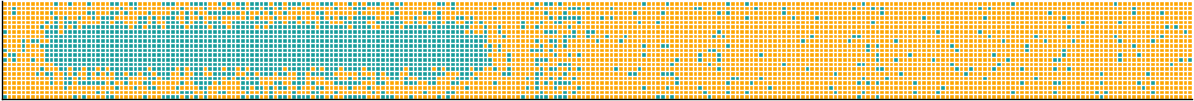

Fraction of total elements active in the ROM: 30.009337068160598%
residual=8.494600465078418e-16


In [ ]:
plt.rcParams['figure.dpi'] = 200
plot(0,0,0).element_((d.ncells[0],d.ncells[1]), xi, d.ncells)
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")
print(f"{residual=}")

In [ ]:
# Data_cls.FOS.data.n_verts


### ROM Simulation

In [ ]:
Data_cls.mean = NLS_train_mean

In [ ]:
ROM_h = bc.ROM_simulation(Data_cls, V_sel, xi, sol_init_guess=298.0) #, N_rom_snap=1)
ROM_h.run_simulation_ms()

TypeError: convert_to_ss() takes 2 positional arguments but 3 were given

In [ ]:
ROM = bc.ROM_simulation(Data_cls, V_sel, sol_init_guess=298.0) #, xi=xi)#, N_rom_snap=1)
ROM.run_simulation_ms()

### Performance Statistics

In [ ]:
NLS_rom_h = np.asarray(ROM_h.NL_solutions_rom[0])
ROM_speed_up_h = ROM_h.speed_up
print(ROM_speed_up_h)

[92.52207758060456]


In [ ]:
NLS_rom = np.asarray(ROM.NL_solutions_rom[0])
ROM_speed_up = ROM.speed_up
print(ROM_speed_up)

[11.71745560343166]


In [ ]:
err= np.linalg.norm(NLS_rom-NLS[0])/np.linalg.norm(NLS[0]-298)
print(err)

2.7396136383284718e-09


In [ ]:
err= np.linalg.norm(NLS_rom_h-NLS[0])/np.linalg.norm(NLS[0]-298)
print(f"--------\n{err=}\n---------")

--------
err=0.0368010550238582
---------


In [ ]:
a=100

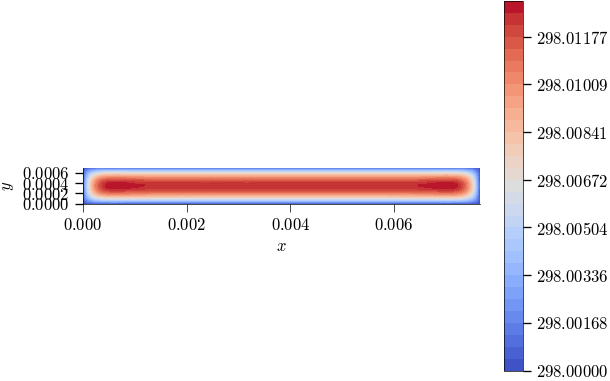

In [ ]:
plt.rcParams['figure.dpi'] = 100
Plot = plot(d.xi[0], d.xi[1], NLS_rom_h[:,a])
Plot.contour_()

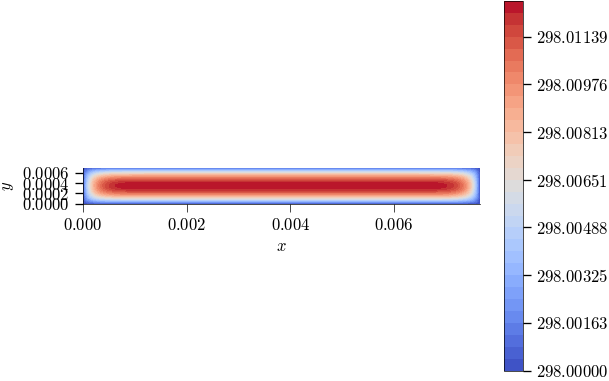

In [ ]:
Plot = plot(d.xi[0], d.xi[1], NLS_rom[:,a])
Plot.contour_()

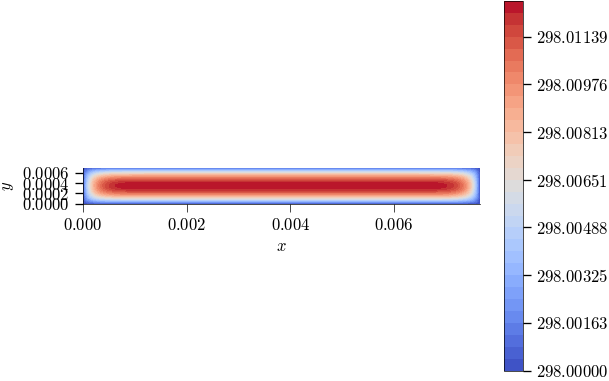

In [ ]:
Plot = plot(d.xi[0], d.xi[1], NLS[0][:,a])
Plot.contour_()

In [ ]:
# ROM_SOL = ROM.NL_solutions_rom[0]
# fig, ax = plt.subplots(figsize=(5,3.5))

# for i in range(Snap_sel*10):
#     Plot = plot(d.xi[0], ROM_SOL[0][::2,i], ax=ax)
#     Plot.line_()

# plt.show()